В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/edce80b5bb02479085855b2334b17fc1). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [290]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import root_mean_squared_error
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Area under ROC score on Train dataset: 0.88%


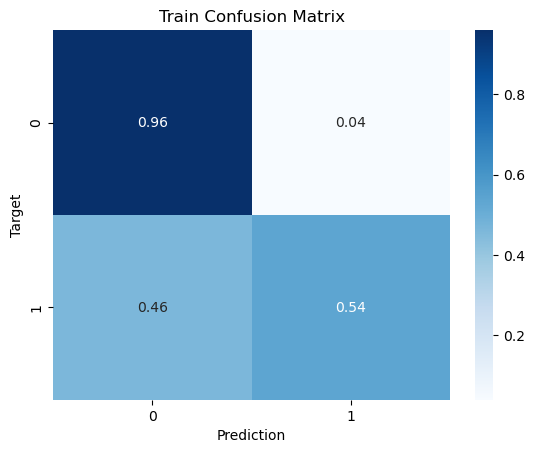

Area under ROC score on Validation dataset: 0.88%


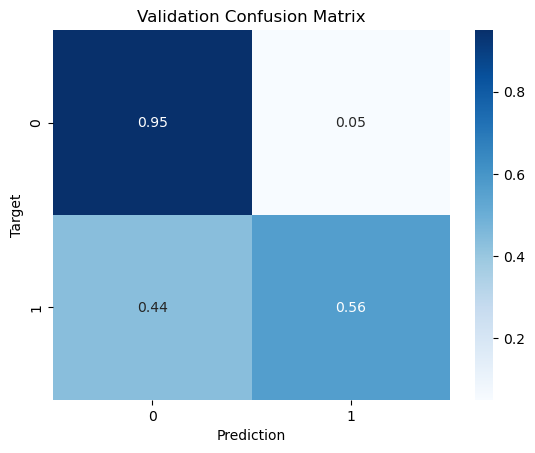

['exited_pipeline.joblib']

In [292]:
df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/train.csv', index_col=0)

# видаляю стовпцi id та customerID
df.drop(columns=['CustomerId'], inplace = True)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42,  stratify = df.Exited)

# Створюємо трен. і вал. набори
input_cols = list(df.columns)[:-1]
target_col = 'Exited'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include = np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()
categorical_cols.remove('Surname')

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])
    
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'exited_pipeline.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [295]:
numeric_transformer_poly = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', MinMaxScaler())
])

preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear'))
])

In [297]:
model_pipeline_poly.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

Area under ROC score on Train dataset: 0.91%


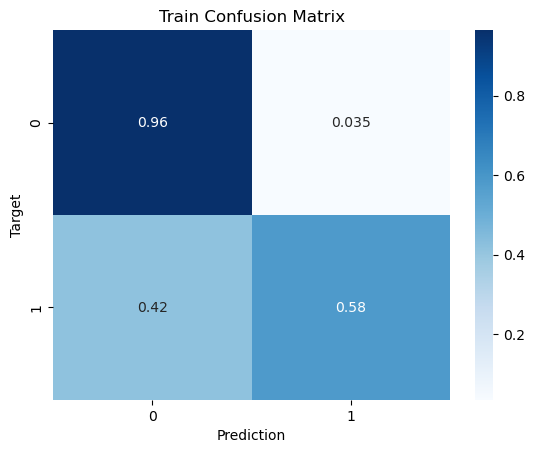

Area under ROC score on Validation dataset: 0.91%


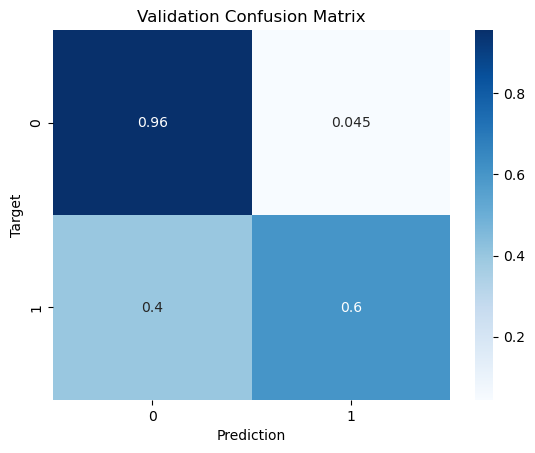

In [299]:
train_preds = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, 'Validation')

При додаванні поліноміальних фіч модель гарно генералізує дані, auc = 0.91 для обох вибірок, це означає що немає ні перенавчання ні недонавчання.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

In [303]:
numeric_transformer_poly4 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=4)),
    ('scaler', MinMaxScaler())
])

preprocessor_poly4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', LogisticRegression(solver='liblinear'))
])

In [305]:
model_pipeline_poly4.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=4)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

Area under ROC score on Train dataset: 0.93%


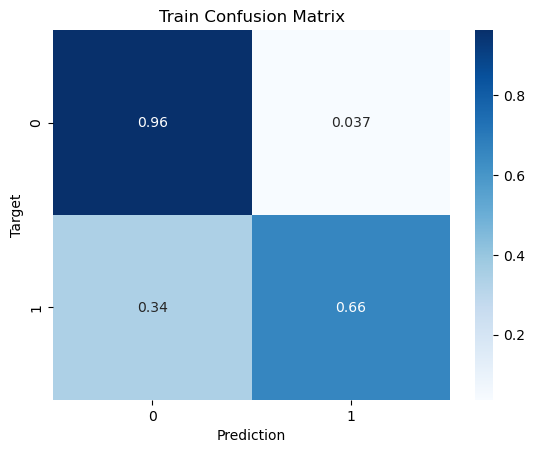

Area under ROC score on Validation dataset: 0.93%


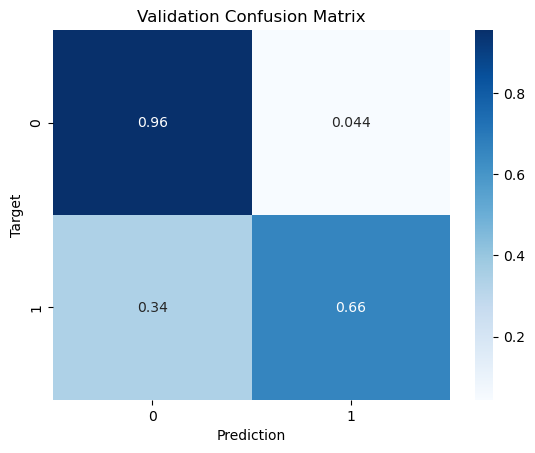

In [306]:
train_preds = predict_and_plot(model_pipeline_poly4, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline_poly4, val_inputs, val_targets, 'Validation')

При додаванні поліноміальних фіч до 4 степені модель покращилась до якості auc = 0.93.

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [311]:
reg_data = pd.read_csv('regression_data.csv')

In [313]:
reg_data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [315]:
train_df, test_df = train_test_split(reg_data, test_size=0.2, random_state=42)

In [317]:
input_cols = list(reg_data.columns)[:-1]
target_col = 'target'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [319]:
numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=5)),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, input_cols)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regression', LinearRegression())
])

In [321]:
model_pipeline.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=5)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'feature_4',
                                                   'feature_5'])])),
                ('regression', LinearRegression())])

In [323]:
y_pred_train = model_pipeline.predict(train_inputs)
rmse_lin_train = root_mean_squared_error(train_targets, y_pred_train)

y_pred_test = model_pipeline.predict(test_inputs)
rmse_lin_test = root_mean_squared_error(test_targets, y_pred_test)

In [325]:
print(f"Train RMSE: {rmse_lin_train:.15f}")
print(f"Test RMSE: {rmse_lin_test:.15f}\n")

Train RMSE: 0.000000000000210
Test RMSE: 12.437664111678037



In [327]:
test_targets.mean(), train_targets.std()

(6.190106769386836, 44.35003659161174)

Модель перенавчена - на тренувальних даних помилка 0, тобто вона вивчила тренувальні, а на тестових помилка 12.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [331]:
models = [
    LinearRegression(),
    Ridge(),
    Ridge(alpha=0.05),
    Lasso(),
    ElasticNet(),
    ElasticNet(alpha=0.5)
]

In [333]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_metrics = root_mean_squared_error(y_train, y_train_pred).round(6)
    test_metrics = root_mean_squared_error(y_test, y_test_pred).round(6)

    return dict(train=train_metrics, test=test_metrics)

In [335]:
poly_features = PolynomialFeatures(degree=20)
X_train_poly = poly_features.fit_transform(train_inputs)
X_test_poly = poly_features.transform(test_inputs)

scaler = MinMaxScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

In [337]:
for model in models:
    model.fit(X_train_poly_scaled, train_targets)
    eval_results  = evaluate_model(model, X_train_poly_scaled, train_targets, X_test_poly_scaled, test_targets)
    print(f'{str(model)}: {eval_results}\n')

LinearRegression(): {'train': 0.0, 'test': 19.335666}

Ridge(): {'train': 8.59775, 'test': 76.562708}

Ridge(alpha=0.05): {'train': 1.161955, 'test': 20.163323}

Lasso(): {'train': 5.098171, 'test': 5.671931}

ElasticNet(): {'train': 34.179765, 'test': 116.029707}

ElasticNet(alpha=0.5): {'train': 29.38021, 'test': 154.530517}



In [338]:
lasso = Lasso().fit(X_train_poly_scaled, train_targets)
coefficients = lasso.coef_

In [339]:
poly_columns = poly_features.get_feature_names_out(input_features=input_cols)

In [340]:
non_zero_features = [poly_columns[i] for i in range(len(coefficients)) if coefficients[i] != 0]

In [342]:
non_zero_features

['feature_4']

Найкраще генералізує модель Lasso(), оскільки вона не перенавчена, як усі інші - RMSE на тренувальних та тестових даних дуже близькі. 

Ця модель використовує регуляризацію для боротьби з перенавчанням, обнуляючи коєфіцієнти неважливих ознак. В цих даних важливою виявилася лише ознака feature_4.